# Visión por Computadora I - Trabajo Práctico 3
### Alumna: Noelia Qualindi | Cohorte 14 | Año 2024

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en Material_TPs/TP3/images a partir del template Material_TPs/TP3/template

1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos 
2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen
coca_multi.png con el mismo témplate del ítem 1
3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes.

Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza
de la detección.

In [16]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [25]:
# Cargar el template del logo de Coca-Cola
# Ruta a la carpeta de imágenes y template
images_path = 'images'
template_path = 'template/pattern.png'

#### Detección del logotipo usando pirámides gaussianas + Template Matching 

In [26]:
def load_template(template_path):
    template = cv.imread(template_path, cv.IMREAD_GRAYSCALE)
    return template

In [27]:
def load_images_from_folder(folder):
    images = []
    filenames = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
            filenames.append(filename)
    return filenames, images

In [20]:
def resize_image(image, width=None, height=None):
    h, w = image.shape[:2]
    if width is None and height is None:
        return image
    if width is None:
        ratio = height / h
        dimension = (int(w * ratio), height)
    else:
        ratio = width / w
        dimension = (width, int(h * ratio))
    resized_image = cv.resize(image, dimension, interpolation=cv.INTER_AREA)
    return resized_image

In [21]:
def template_matching_multi_scale(image, template_gray, methods, threshold):
    # Pirámide gaussiana del template
    pyramid = [template_gray]

    temp_shape = template_gray.shape
    for _ in range(2):
        template_gray = cv.pyrDown(template_gray)
        pyramid.append(template_gray)

    detections = []

    for method in methods:
        for scale, t in enumerate(pyramid):
            if image.shape[0] < t.shape[0] or image.shape[1] < t.shape[1]:
                continue

            result = cv.matchTemplate(image, t, method)
            min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result)

            if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
                match_confidence = 1 - min_val
                match_loc = min_loc
            else:
                match_confidence = max_val
                match_loc = max_loc

            if match_confidence >= threshold:
                bbox = (*match_loc, match_loc[0] + t.shape[1], match_loc[1] + t.shape[0])
                detections.append((bbox, match_confidence, method))

    return detections


In [22]:
def show_results(images, all_detections, methods):
    for i, img in enumerate(images):
        img_copy = img.copy()

        for method in methods:
            detections = all_detections[method][i]
            for j, det in enumerate(detections):
                bbox, confidence, _ = det
                cv.rectangle(img_copy, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
                cv.putText(img_copy, f'{method}: {confidence:.2f}', (bbox[0], bbox[1] - 10),
                           cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        plt.figure(figsize=(10, 6))
        plt.imshow(cv.cvtColor(img_copy, cv.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f'Detection Results for Image {i + 1}')
        plt.show()



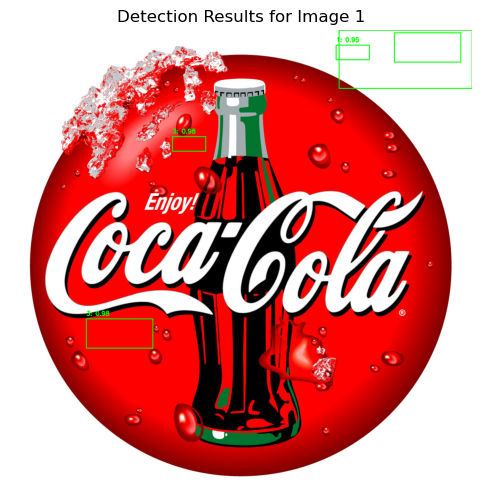

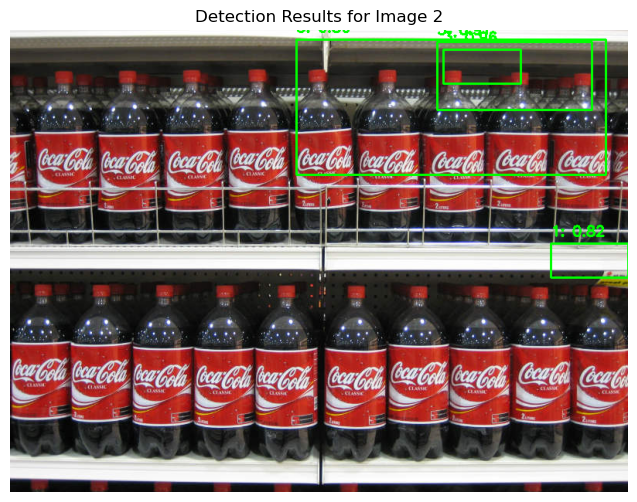

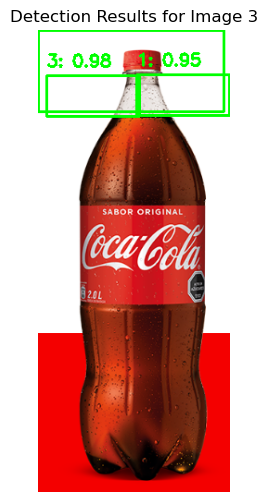

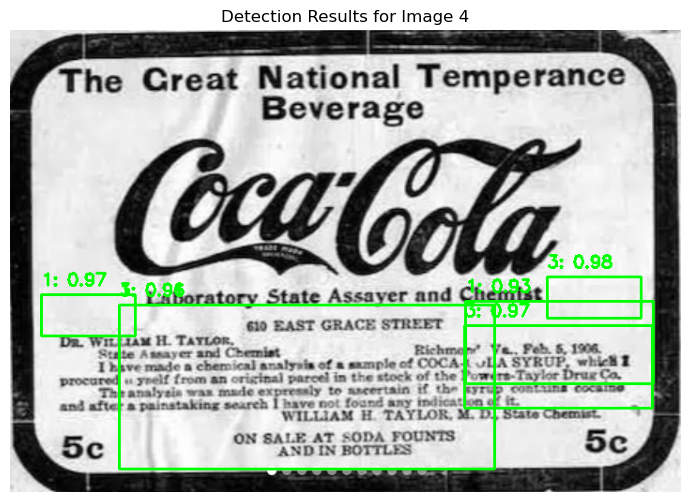

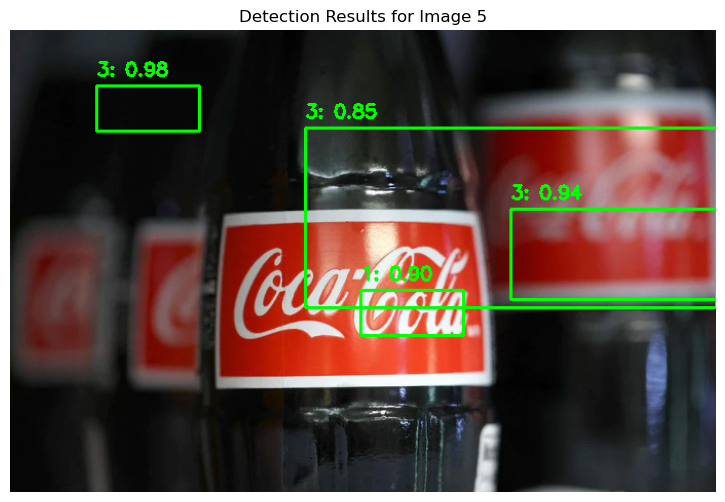

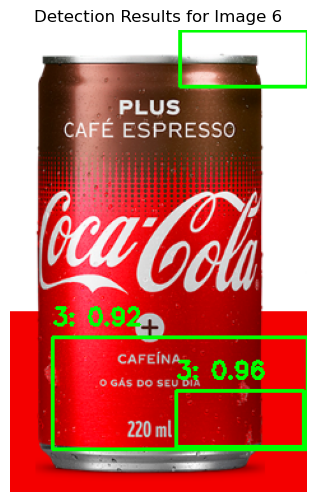

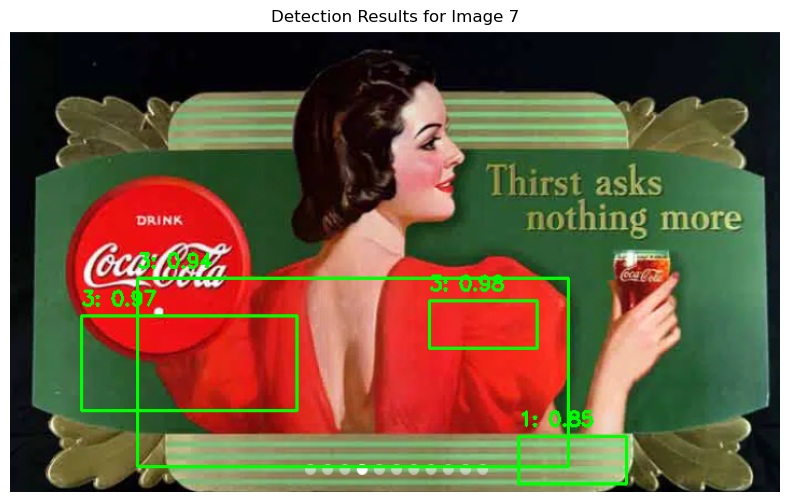

In [23]:
# Métodos de template matching a probar
methods = [cv.TM_CCOEFF_NORMED, cv.TM_CCORR_NORMED, cv.TM_SQDIFF_NORMED]

template = load_template(template_path)
filenames, images = load_images_from_folder(images_path)
# Umbral de confianza
threshold = 0.8

detections = []

all_detections = {method: [] for method in methods}
for img in images:
    gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # template matching con pirámide gaussiana para cada método
    for method in methods:
        det = template_matching_multi_scale(gray_img, template, [method], threshold)
        all_detections[method].append(det)

show_results(images, all_detections, methods)

### Detección del logotipo usando pirámides gaussianas + SIFT + Template Matching 

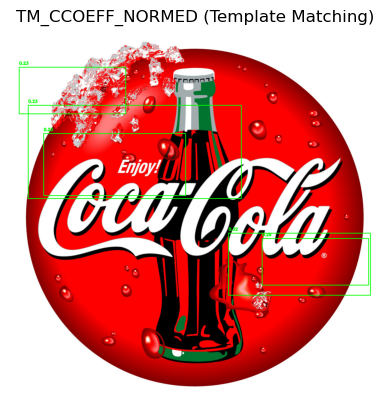

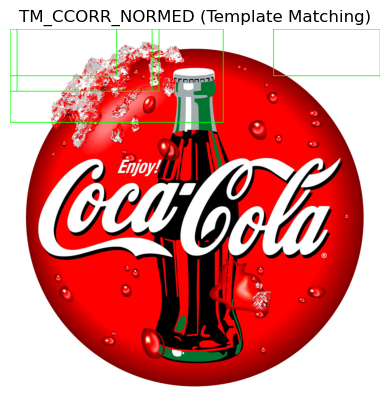

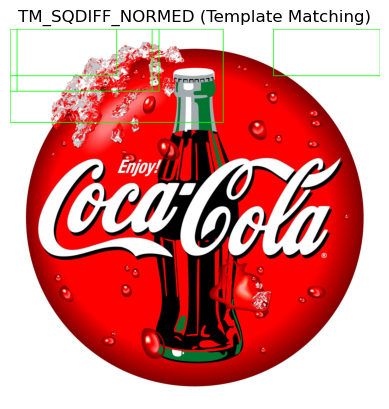

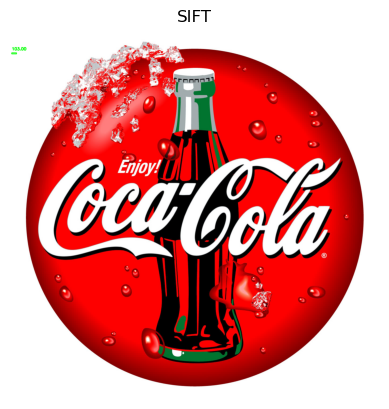

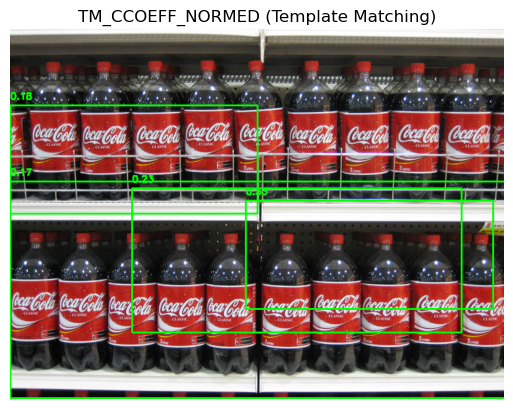

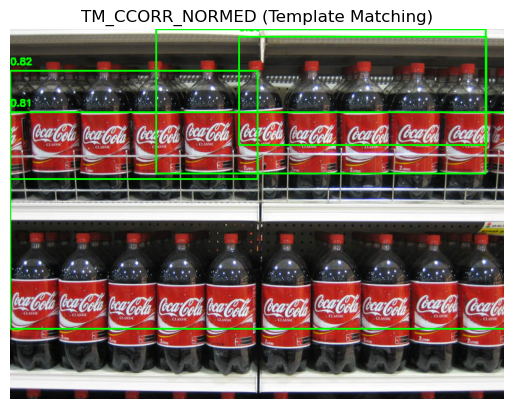

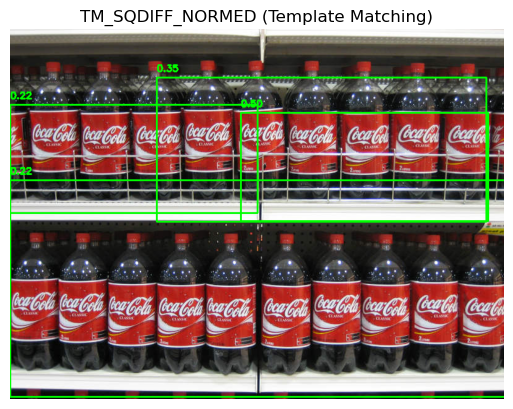

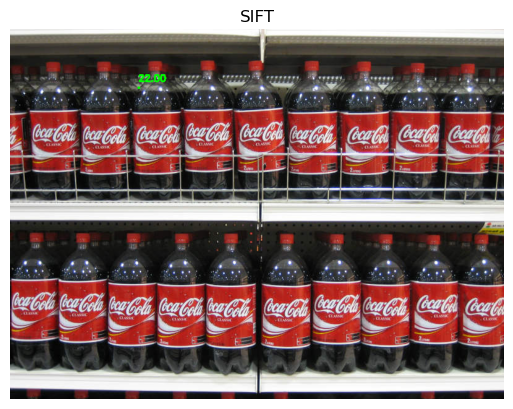

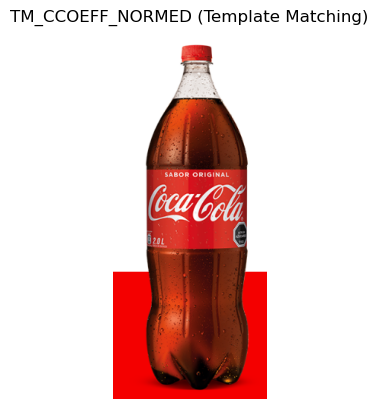

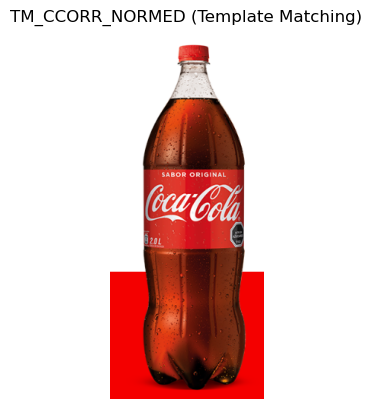

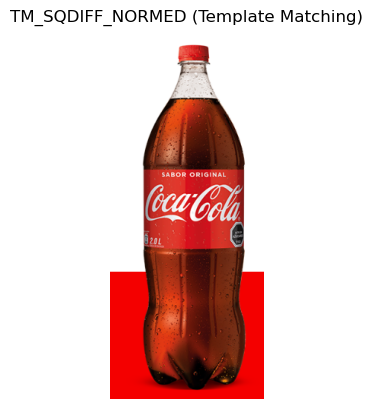

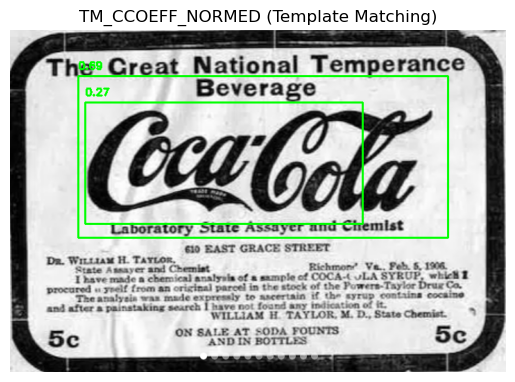

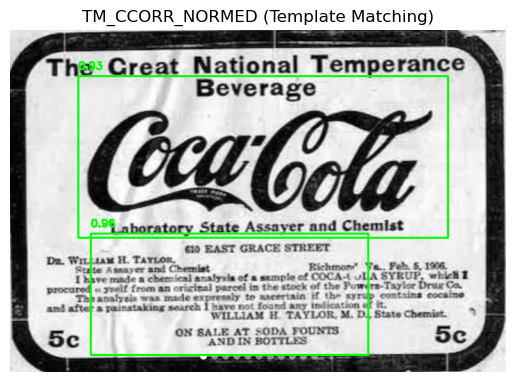

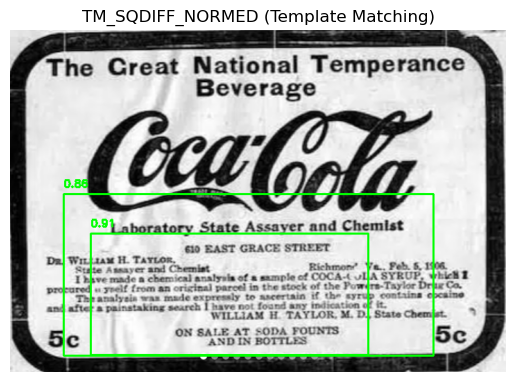

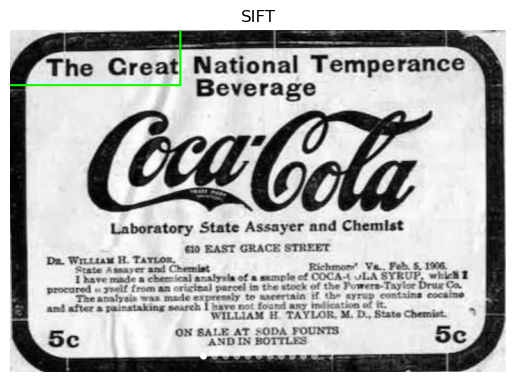

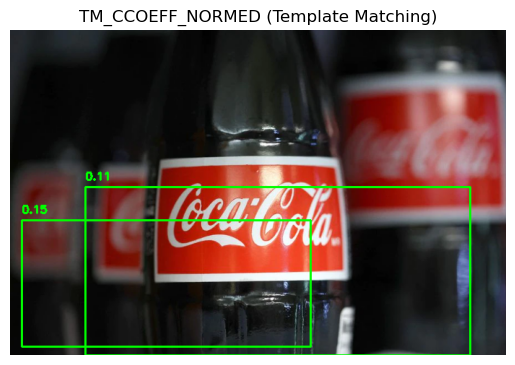

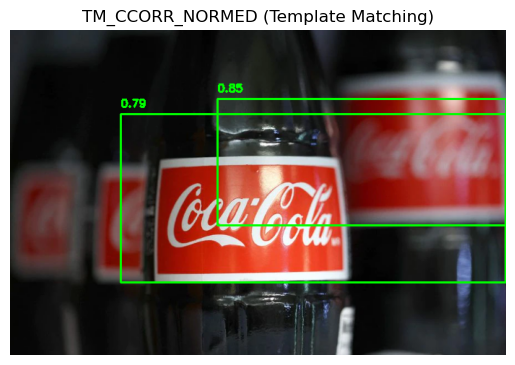

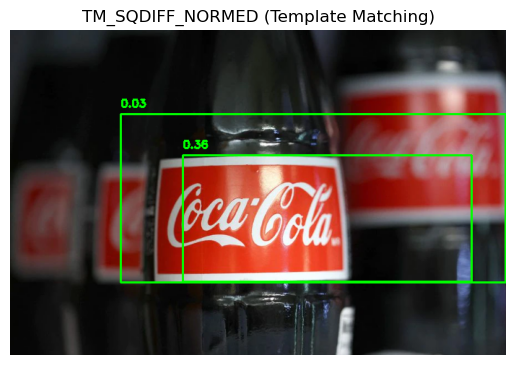

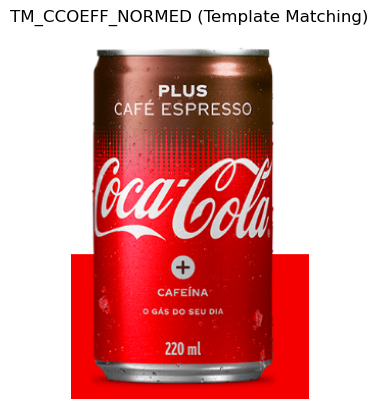

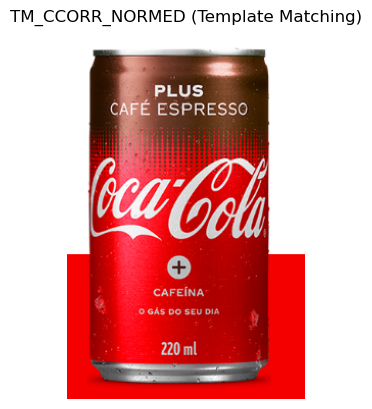

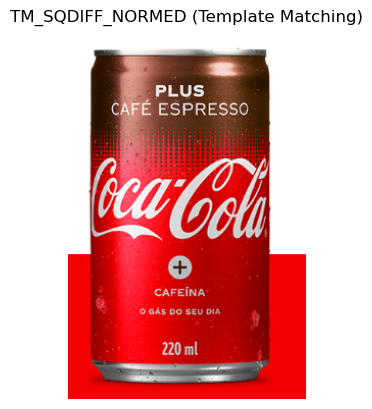

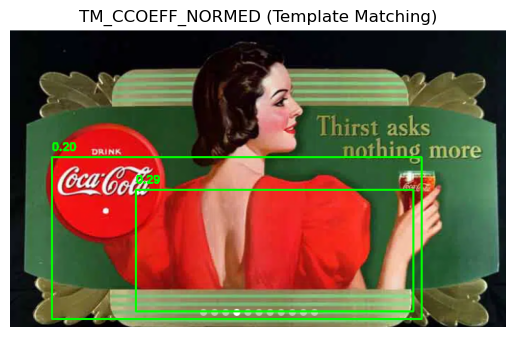

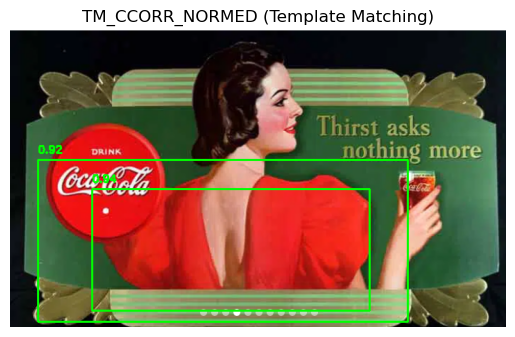

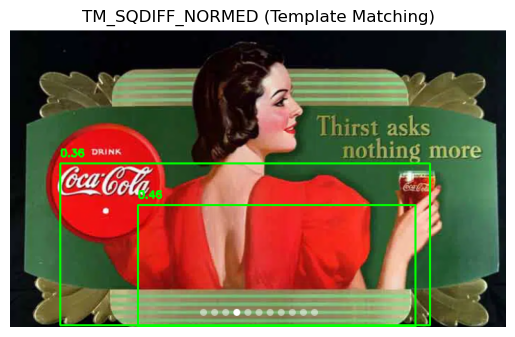

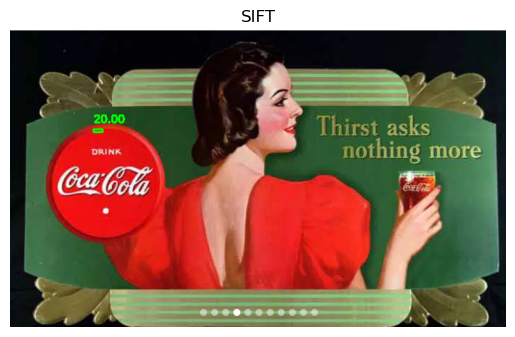

In [29]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os

template = load_template(template_path)
filenames, images = load_images_from_folder(images_path)

# mostrar imágenes con bounding boxes
def show_image_with_bboxes(image, bboxes, confidences, method_name):
    for bbox, confidence in zip(bboxes, confidences):
        x, y, w, h = bbox
        cv.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv.putText(image, f'{confidence:.2f}', (x, y - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    plt.title(method_name)
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# redimensionar la imagen y el template según el tamaño de la imagen
def resize_image_and_template(image, template):
    img_height, img_width = image.shape[:2]
    template_height, template_width = template.shape[:2]

    # factor de escala basado en la altura de la imagen
    scale_factor = img_height / 500.0
    resized_image = cv.resize(image, (int(img_width / scale_factor), int(img_height / scale_factor)))

    # nuevo tamaño del template
    template_resized = cv.resize(template, (0, 0), fx=1.0 / scale_factor, fy=1.0 / scale_factor)

    return resized_image, template_resized

# redimensionar la imagen y realizar template matching
def template_matching(image, template, method):
    h, w = template.shape
    img_h, img_w = image.shape

    # Verificar si la imagen es más pequeña que el template
    if img_h < h or img_w < w:
        return (0, 0, 0, 0), 0.0

    result = cv.matchTemplate(image, template, method)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result)

    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
        confidence = 1 - min_val  # En TM_SQDIFF y TM_SQDIFF_NORMED, valores menores son mejores
    else:
        top_left = max_loc
        confidence = max_val

    bottom_right = (top_left[0] + w, top_left[1] + h)
    return (top_left[0], top_left[1], w, h), confidence

# detectar logotipos usando pirámide gaussiana y SIFT
def detect_logo_with_methods(image, template, methods, scale_factors=[1.0, 0.75, 0.5, 0.25]):
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    all_results = {}

    for method in methods:
        method_name = method_to_string(method)
        bboxes = []
        confidences = []

        for scale in scale_factors:
            resized_image = cv.resize(gray_image, None, fx=scale, fy=scale, interpolation=cv.INTER_LINEAR)

            # Verificar que la imagen redimensionada sea mayor o igual que el template
            if resized_image.shape[0] < template.shape[0] or resized_image.shape[1] < template.shape[1]:
                continue

            # Pirámide gaussiana para generar diferentes escalas de la imagen
            pyr_image = resized_image.copy()
            while pyr_image.shape[0] >= template.shape[0] and pyr_image.shape[1] >= template.shape[1]:
                bbox, confidence = template_matching(pyr_image, template, method)
                bbox = (int(bbox[0] / scale), int(bbox[1] / scale), int(bbox[2] / scale), int(bbox[3] / scale))

                bboxes.append(bbox)
                confidences.append(confidence)

                pyr_image = cv.pyrDown(pyr_image)

        all_results[method_name] = (bboxes, confidences)

    return all_results

def method_to_string(method):
    if method == cv.TM_CCOEFF:
        return "TM_CCOEFF"
    elif method == cv.TM_CCOEFF_NORMED:
        return "TM_CCOEFF_NORMED"
    elif method == cv.TM_CCORR:
        return "TM_CCORR"
    elif method == cv.TM_CCORR_NORMED:
        return "TM_CCORR_NORMED"
    elif method == cv.TM_SQDIFF:
        return "TM_SQDIFF"
    elif method == cv.TM_SQDIFF_NORMED:
        return "TM_SQDIFF_NORMED"
    else:
        return "Unknown Method"

        

# detectar logotipos usando SIFT
def detect_logo_with_sift(image, template):
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    gray_template = template.copy()

    sift = cv.SIFT_create()

    # Encontrar keypoints y descriptores en la imagen y el template
    kp_image, desc_image = sift.detectAndCompute(gray_image, None)
    kp_template, desc_template = sift.detectAndCompute(gray_template, None)

    # objeto de coincidencia de fuerza bruta usando los descriptores
    bf = cv.BFMatcher()
    matches = bf.knnMatch(desc_image, desc_template, k=2)

    # ratio test para obtener buenos matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    img_matches = cv.drawMatches(image, kp_image, template, kp_template, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # bounding box basado en los matches
    if len(good_matches) > 10:
        src_pts = np.float32([kp_image[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp_template[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        H, _ = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
        h, w = template.shape
        pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
        dst = cv.perspectiveTransform(pts, H)
        bbox = cv.boundingRect(dst)
        confidence = len(good_matches)

        return [(bbox[0], bbox[1], bbox[2], bbox[3])], confidence
    else:
        return [], 0.0

# Métodos a probar
methods = [cv.TM_CCOEFF_NORMED, cv.TM_CCORR_NORMED, cv.TM_SQDIFF_NORMED]

for image_name in os.listdir(image_dir):
    image_path = os.path.join(image_dir, image_name)
    image = cv.imread(image_path)

    # template matching con pirámide gaussiana
    results_template = detect_logo_with_methods(image, template, methods)
    for method_name, (bboxes, confidences) in results_template.items():
        show_image_with_bboxes(image.copy(), bboxes, confidences, method_name + " (Template Matching)")

    # usando SIFT
    bboxes_sift, confidence_sift = detect_logo_with_sift(image, template)
    if confidence_sift > 0:
        show_image_with_bboxes(image.copy(), bboxes_sift, [confidence_sift], "SIFT")

